In [ ]:
!pip install vit-keras
!pip install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from vit_keras import vit
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the Imagenette/160px-v2 dataset
ds_train, ds_test = tfds.load('imagenette/160px-v2', split=['train', 'validation'], as_supervised=True)

In [ ]:
# Convert the train dataset images and labels to numpy arrays
x_train, y_train = [], []

for image, label in ds_train:
    image = tf.image.resize(image, (64, 64))
    x_train.append(image.numpy())
    y_train.append(label.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# Convert the test dataset images and labels to numpy arrays
x_test, y_test = [], []
for img, label in ds_test:
    img = tf.image.resize(img, (64, 64))
    x_test.append(img.numpy())
    y_test.append(label.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print('shape of training images: ', x_train.shape)
print('shape of training images: ', y_train.shape)
print()
print('shape of testing images: ', x_test.shape)
print('shape of testing images: ', y_test.shape)

shape of training images:  (9469, 64, 64, 3)
shape of training images:  (9469,)

shape of testing images:  (3925, 64, 64, 3)
shape of testing images:  (3925,)


In [ ]:
classes = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
           'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

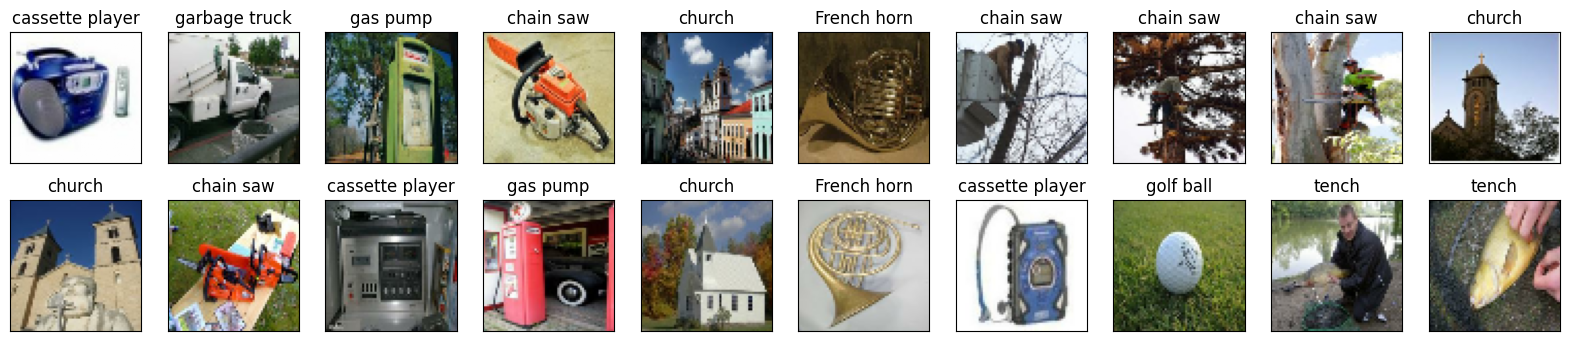

In [ ]:
# show some training sample images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = plt.subplot(2, 10, idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(x_train[idx])
  plt.title(classes[int(y_train[idx])])

In [ ]:
#Define the ViT model
model = vit.vit_l16(image_size = 64, activation = 'softmax', classes = 10)

1218991142/1218991142 [==============================] - 13s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4), loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

In [ ]:

model_path = '/content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/vit_l16_imagenet.h5'
checkpoint = ModelCheckpoint(model_path,
                             monitor= "val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode= "auto",
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss",
                      mode= "auto",
                      patience = 5)

callbacks_list = [checkpoint, early]


In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size = 32, epochs = 30, validation_data = (x_test, y_test), callbacks = callbacks_list)

Epoch 1/30
296/296 [==============================] - ETA: 0s - loss: 1.2723 - accuracy: 0.5914
Epoch 1: val_loss improved from inf to 0.70852, saving model to /content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/vit_l16_imagenet.h5
296/296 [==============================] - 324s 739ms/step - loss: 1.2723 - accuracy: 0.5914 - val_loss: 0.7085 - val_accuracy: 0.7743
Epoch 2/30
296/296 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8431
Epoch 2: val_loss improved from 0.70852 to 0.55056, saving model to /content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/vit_l16_imagenet.h5
296/296 [==============================] - 380s 1s/step - loss: 0.4794 - accuracy: 0.8431 - val_loss: 0.5506 - val_accuracy: 0.8191
Epoch 3/30
296/296 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9249
Epoch 3: val_loss did not improve from 0.55056
296/296 [==============================] - 157s 529ms/step - loss: 0.234

In [ ]:
model = load_model('/content/drive/MyDrive/Adversarial-Robustness-of-ViTs-vs-CNNs/trained_models/vit_l16_imagenet.h5')

In [ ]:
model.summary()

Model: "vit-l16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 4, 4, 1024)        787456    
                                                                 
 reshape (Reshape)           (None, 16, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 17, 1024)          1024      
                                                                 
 Transformer/posembed_input  (None, 17, 1024)          17408     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 17, 1024),        12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [ ]:
# lenght of layers of model
len(model.layers)

32

In [ ]:
# Total number of parameters in millions
total_params = 0
for layer in model.layers:
  total_params += layer.count_params()
print(f'Total number of parameters: {total_params/1000000:.2f}M')

Total number of parameters: 304.14M


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print()
print('Test Accuracy: ', round(test_accuracy, 4))
print('Test Los: ', round(test_loss, 4))

123/123 [==============================] - 24s 144ms/step - loss: 0.5506 - accuracy: 0.8191

Test Accuracy:  0.8191
Test Los:  0.5506


In [ ]:
predictions = model.predict(x_test)

123/123 [==============================] - 23s 148ms/step


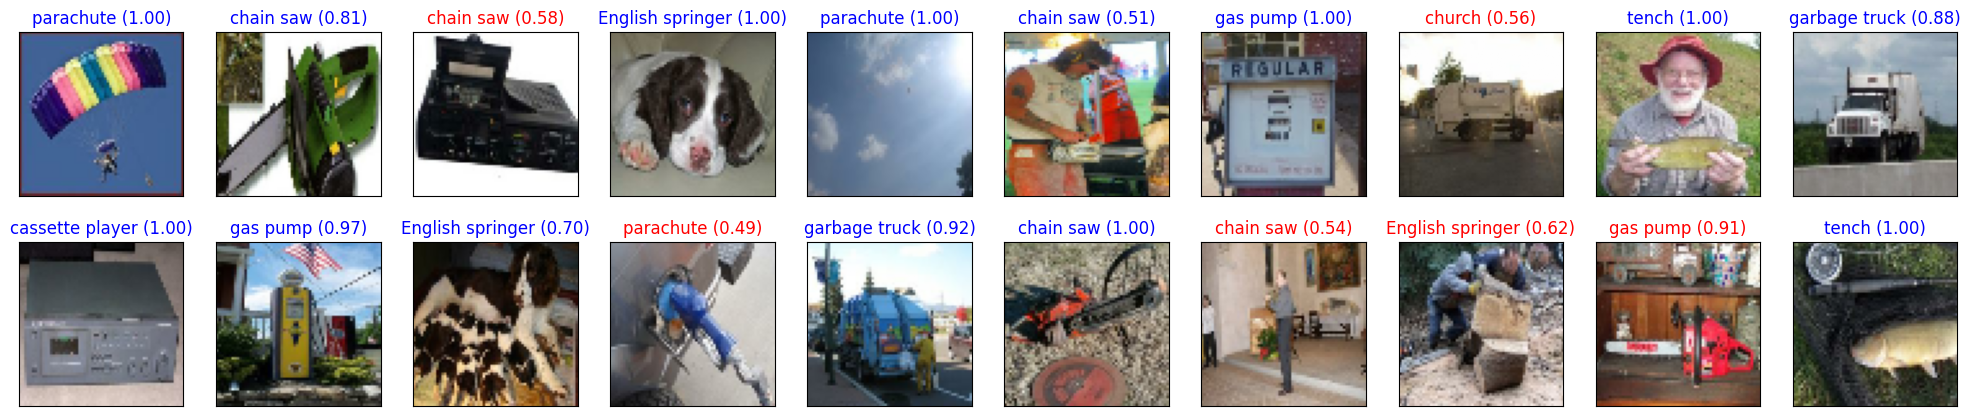

In [ ]:
#show some test images
fig = plt.figure(figsize=(25, 5))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  plt.imshow(x_test[idx])

  if classes[int(y_test[idx])] == classes[int(np.argmax(predictions[idx]))]:
    color = 'blue'
  else:
    color = 'red'

  plt.title('%s (%.2f)' %(classes[np.argmax(predictions[idx])], predictions[idx].max()), color = color)

<h1><b>Adversarial Robustness<b></h1>

## 1. Adversarial Robustness in the Presence of Fast Gradient Sign Attack (FGSM)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def fgsm_attack(model, images, labels, epsilon):
    # Convert images to tf.Tensor
    images = tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Calculate the gradients of the loss with respect to the input images
    gradient = tape.gradient(loss, images)

    # Get the sign of the gradients to create the perturbations
    signed_grad = tf.sign(gradient)

    # Create the adversarial images by adding the perturbations
    adversarial_images = images + epsilon * signed_grad

    # Clip the adversarial images to ensure they are within the valid image range
    adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)

    return adversarial_images

def evaluate_adversarial_accuracy(model, x_test, y_test, epsilon, batch_size=32):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = fgsm_attack(model, x_batch, y_batch, epsilon)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch, verbose=0)
        adv_accuracy += adv_acc * len(x_batch)

    return adv_accuracy / len(x_test)

Epsilon: 0.000, Adversarial Accuracy: 0.8200
Epsilon: 0.003, Adversarial Accuracy: 0.6700
Epsilon: 0.006, Adversarial Accuracy: 0.5200
Epsilon: 0.009, Adversarial Accuracy: 0.3700
Epsilon: 0.012, Adversarial Accuracy: 0.2900
Epsilon: 0.015, Adversarial Accuracy: 0.2200
Epsilon: 0.018, Adversarial Accuracy: 0.1600
Epsilon: 0.021, Adversarial Accuracy: 0.1300
Epsilon: 0.024, Adversarial Accuracy: 0.1300
Epsilon: 0.027, Adversarial Accuracy: 0.1000
Epsilon: 0.030, Adversarial Accuracy: 0.0800


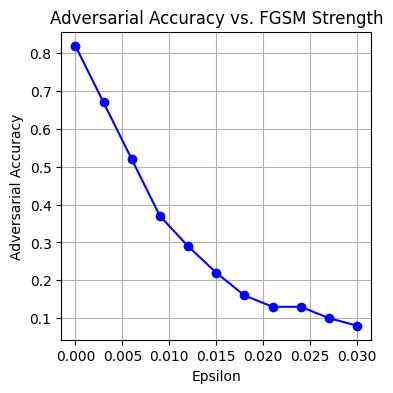

In [ ]:
# Define a range of epsilon values to test the strength of FGSM attacks
epsilon_values = np.linspace(0, 0.03, 11)
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different epsilon values
for epsilon in epsilon_values:
    adv_accuracy = evaluate_adversarial_accuracy(model, x_test[:100], y_test[:100], epsilon, batch_size=32)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Epsilon: {epsilon:.3f}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of epsilon
plt.figure(figsize=(4, 4))
plt.plot(epsilon_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. FGSM Strength')
plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 74ms/step


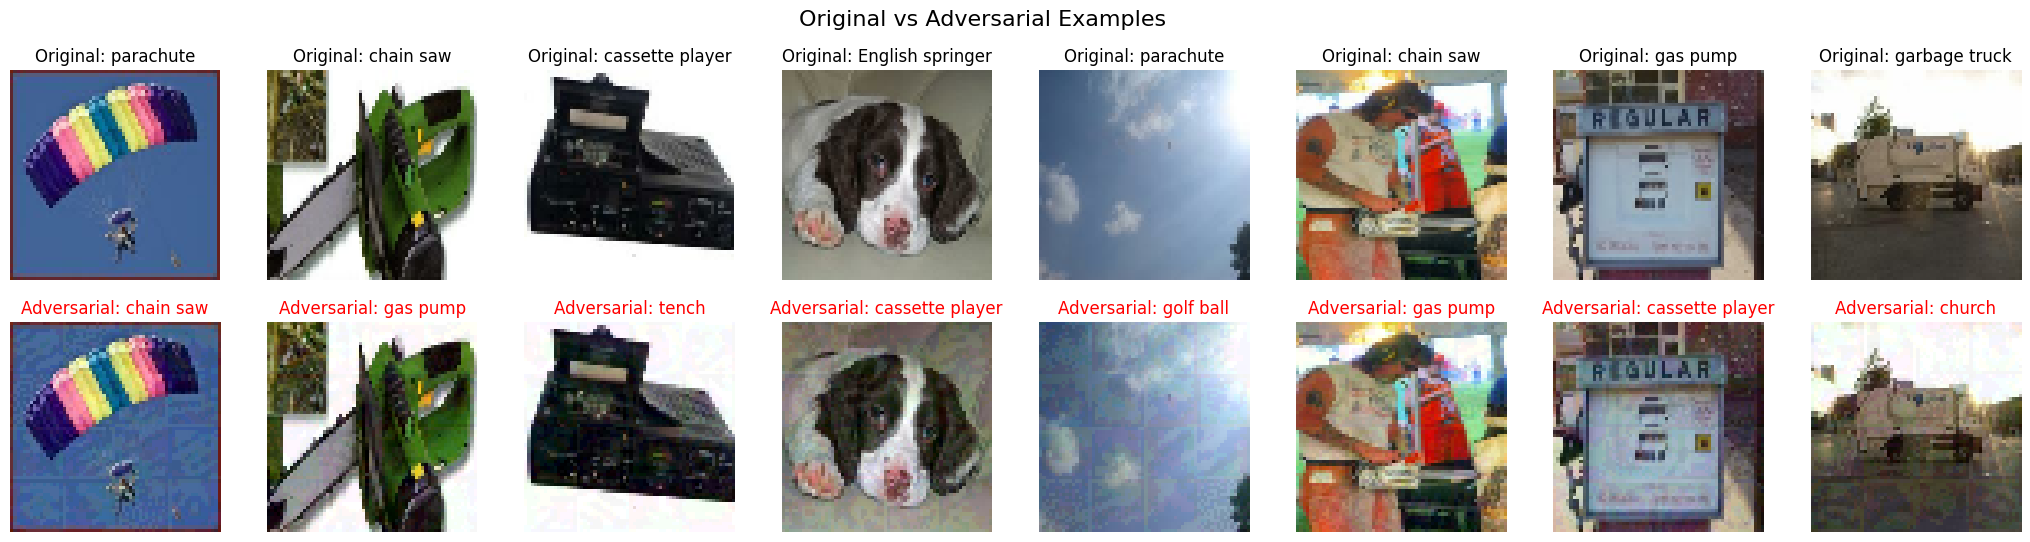

In [ ]:
# Select a subset of test images for visualization
num_examples = 8
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Define epsilon value for FGSM attack
epsilon = 0.03

# Generate adversarial examples
adv_examples = fgsm_attack(model, x_sample, y_sample, epsilon)

# Plot original and adversarial images
fig, axes = plt.subplots(2, num_examples, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples', fontsize=16)

for i in range(num_examples):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[y_sample[i]]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples[i].numpy())
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[y_sample[i]] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()

#2. Projected Gradient Descent Attack and Reconstruction of Adverasarial Examples

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def pgd_attack(model, images, labels, epsilon, alpha, num_iterations):
    # Convert images to tf.Tensor
    images = tf.convert_to_tensor(images)
    original_images = images

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(images)
            predictions = model(images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

        # Calculate the gradients of the loss with respect to the input images
        gradient = tape.gradient(loss, images)

        # Get the sign of the gradients to create the perturbations
        signed_grad = tf.sign(gradient)

        # Create the adversarial images by adding the perturbations
        images = images + alpha * signed_grad

        # Clip the perturbations to ensure they are within the epsilon-ball around the original images
        images = tf.clip_by_value(images, original_images - epsilon, original_images + epsilon)

        # Clip the adversarial images to ensure they are within the valid image range
        images = tf.clip_by_value(images, 0, 1)

    return images

In [ ]:
def evaluate_adversarial_accuracy(model, x_test, y_test, epsilon, alpha, num_iterations, batch_size=32):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = pgd_attack(model, x_batch, y_batch, epsilon, alpha, num_iterations)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch, verbose=0)
        adv_accuracy += adv_acc * len(x_batch)

    return adv_accuracy / len(x_test)

Epsilon: 0.000, Adversarial Accuracy: 0.8200
Epsilon: 0.001, Adversarial Accuracy: 0.7800
Epsilon: 0.002, Adversarial Accuracy: 0.7200
Epsilon: 0.003, Adversarial Accuracy: 0.6700
Epsilon: 0.004, Adversarial Accuracy: 0.5900
Epsilon: 0.005, Adversarial Accuracy: 0.5500
Epsilon: 0.006, Adversarial Accuracy: 0.4700
Epsilon: 0.007, Adversarial Accuracy: 0.4100
Epsilon: 0.008, Adversarial Accuracy: 0.2900
Epsilon: 0.009, Adversarial Accuracy: 0.2300
Epsilon: 0.010, Adversarial Accuracy: 0.1800


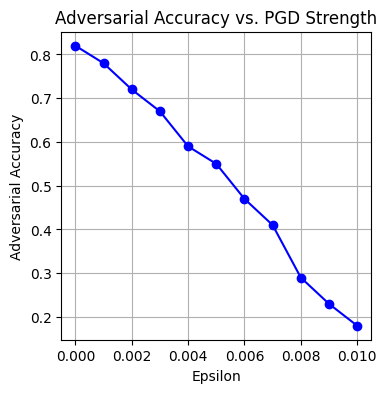

In [ ]:
# Parameters for PGD attack
alpha = 0.01
num_iterations = 20

# Define a range of epsilon values to test the strength of PGD attacks
epsilon_values = np.linspace(0, 0.01, 11)
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different epsilon values
for epsilon in epsilon_values:
    adv_accuracy = evaluate_adversarial_accuracy(model, x_test[:100], y_test[:100], epsilon, alpha, num_iterations, batch_size=32)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Epsilon: {epsilon:.3f}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of epsilon
plt.figure(figsize=(4, 4))
plt.plot(epsilon_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. PGD Strength')
plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 115ms/step


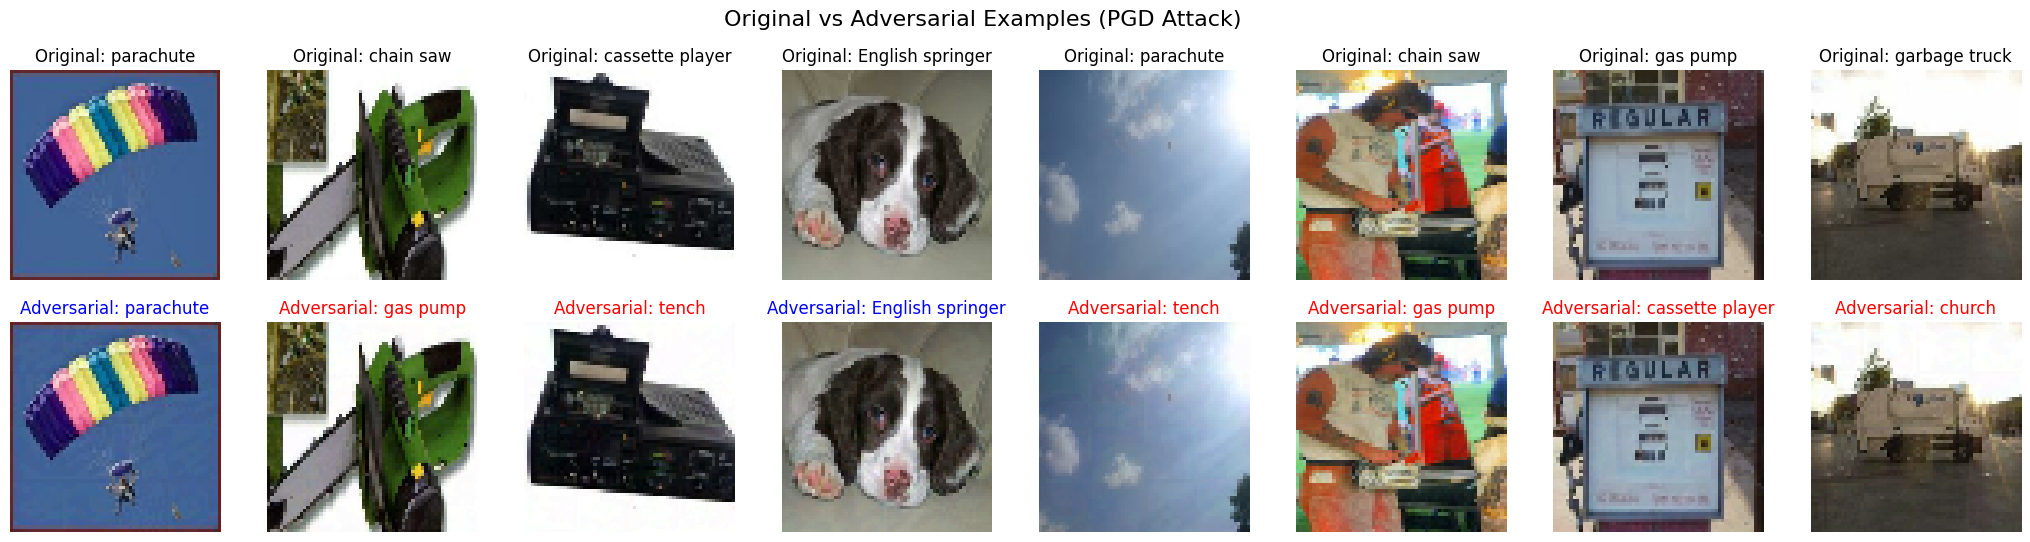

In [ ]:
# Parameters for PGD attack
epsilon = 0.01
alpha = 0.01
num_iterations = 10

# Select a subset of test images for visualization
num_examples = 8
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Generate adversarial examples using PGD
adv_examples_pgd = pgd_attack(model, x_sample, y_sample, epsilon, alpha, num_iterations)

# Plot original and adversarial images
fig, axes = plt.subplots(2, num_examples, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples (PGD Attack)', fontsize=16)

for i in range(num_examples):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[y_sample[i]]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples_pgd[i].numpy())
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples_pgd[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[y_sample[i]] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()

#3. Deep Fool Attack

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def deepfool_attack(model, image, num_classes=10, overshoot=0.02, max_iter=50):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)
    original_image = tf.identity(image)

    f_image = model(image).numpy().flatten()
    I = np.argsort(f_image)[::-1]
    label = I[0]

    pert_image = image
    w = np.zeros(image.shape)
    r_tot = np.zeros(image.shape)

    loop_i = 0
    while loop_i < max_iter:
        with tf.GradientTape() as tape:
            tape.watch(pert_image)
            predictions = model(pert_image)
            loss = predictions[0, label]

        gradients = tape.gradient(loss, pert_image)
        gradients = gradients.numpy()

        pert = np.inf
        for k in range(1, num_classes):
            with tf.GradientTape() as tape:
                tape.watch(pert_image)
                predictions_k = model(pert_image)
                loss_k = predictions_k[0, I[k]]
            gradients_k = tape.gradient(loss_k, pert_image)
            gradients_k = gradients_k.numpy()

            w_k = gradients_k - gradients
            f_k = predictions[0, I[k]] - predictions[0, I[0]]
            pert_k = abs(f_k) / (np.linalg.norm(w_k.flatten()) + 1e-8)  # Added epsilon for numerical stability

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = (pert + 1e-4) * w / (np.linalg.norm(w) + 1e-8)  # Added epsilon for numerical stability
        r_tot = r_tot + r_i

        pert_image = pert_image + (1 + overshoot) * r_i
        pert_image = tf.clip_by_value(pert_image, 0, 1)

        k_i = np.argmax(model(pert_image).numpy().flatten())

        if k_i != label:
            break

        loop_i += 1

    adv_image = pert_image
    return adv_image[0]

def generate_deepfool_adversarial_examples(model, images, max_iter=50, overshoot=0.02):
    adv_images = []
    for idx, image in enumerate(images):
        try:
            adv_image = deepfool_attack(model, image, max_iter=max_iter, overshoot=overshoot)
            adv_images.append(adv_image.numpy())
        except Exception as e:
            print(f"Error generating adversarial example for image {idx}: {e}")
            continue
    return np.array(adv_images)

In [ ]:
def evaluate_deepfool_adversarial_accuracy(model, x_test, y_test, batch_size=32, max_iter=20, overshoot=0.02):
    num_batches = int(np.ceil(len(x_test) / batch_size))
    adv_accuracy = 0

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_test))
        x_batch = x_test[start_idx:end_idx]
        y_batch = y_test[start_idx:end_idx]

        adv_images = generate_deepfool_adversarial_examples(model, x_batch, max_iter=max_iter, overshoot=overshoot)
        if len(adv_images) == 0:
            print("Warning: No adversarial examples were generated for the current batch.")
            continue
        adv_images = tf.convert_to_tensor(adv_images, dtype=tf.float32)
        adv_loss, adv_acc = model.evaluate(adv_images, y_batch[:len(adv_images)], verbose=0)
        adv_accuracy += adv_acc * len(adv_images)

    return adv_accuracy / len(x_test)

Max Iterations: 0, Adversarial Accuracy: 0.8200
Max Iterations: 1, Adversarial Accuracy: 0.2100
Max Iterations: 2, Adversarial Accuracy: 0.1900
Max Iterations: 3, Adversarial Accuracy: 0.1800


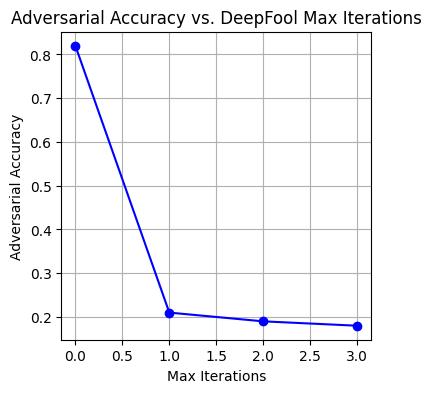

In [ ]:
# Select a subset of test images for visualization and attack
num_examples = 100
x_sample = x_test[:num_examples]
y_sample = y_test[:num_examples]

# Define a range of max_iter values to test the strength of DeepFool attacks
max_iter_values = [0, 1, 2, 3]
adversarial_accuracies = []

# Evaluate the model on adversarial examples generated with different max_iter values
for max_iter in max_iter_values:
    adv_accuracy = evaluate_deepfool_adversarial_accuracy(model, x_sample, y_sample, batch_size=32, max_iter=max_iter, overshoot=0.02)
    adversarial_accuracies.append(adv_accuracy)
    print(f'Max Iterations: {max_iter}, Adversarial Accuracy: {adv_accuracy:.4f}')

# Plot the adversarial accuracy as a function of max iterations
plt.figure(figsize=(4, 4))
plt.plot(max_iter_values, adversarial_accuracies, marker='o', linestyle='-', color='b')
plt.title('Adversarial Accuracy vs. DeepFool Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Adversarial Accuracy')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 75ms/step


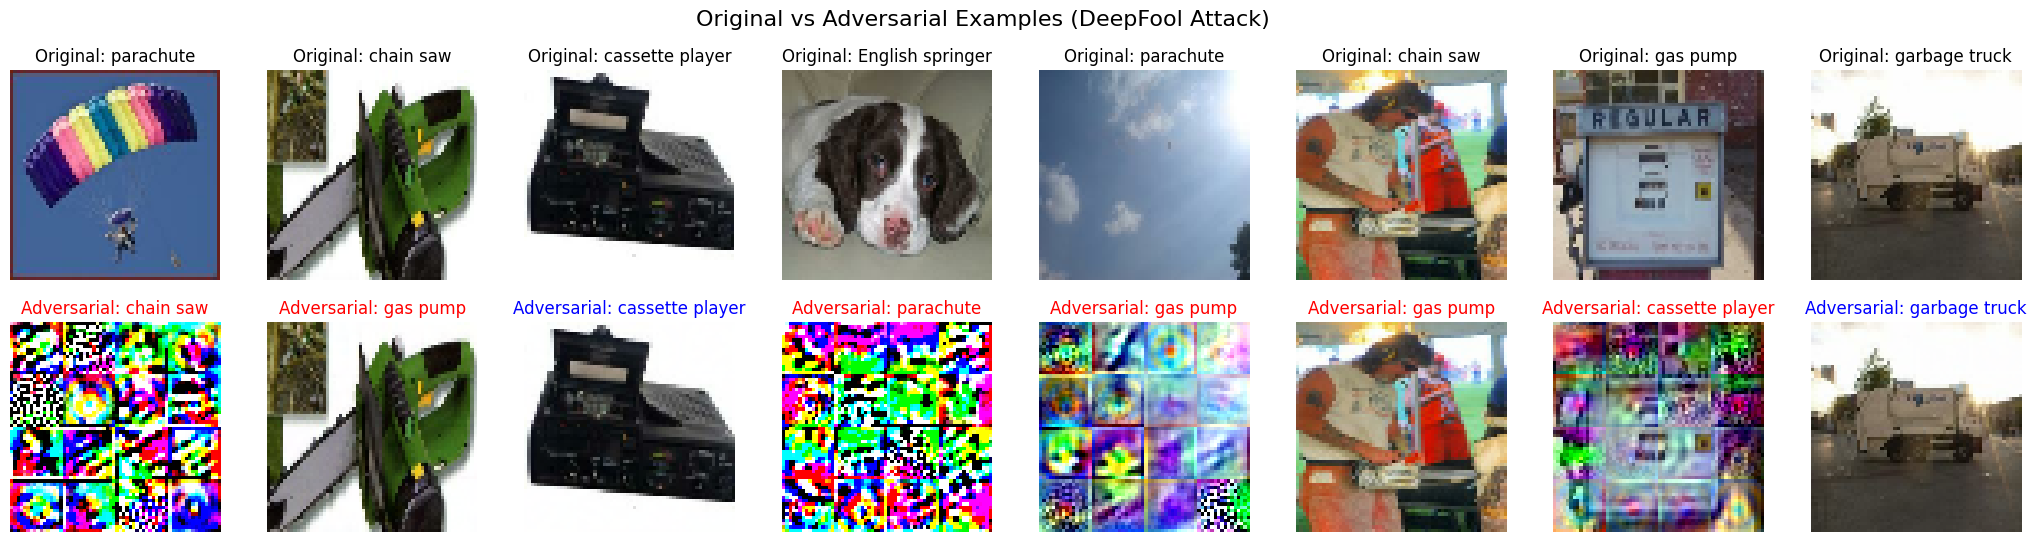

In [ ]:
# Generate adversarial examples using DeepFool
adv_examples_deepfool = generate_deepfool_adversarial_examples(model, x_sample[:8])

if len(adv_examples_deepfool) == 0:
    raise ValueError("No adversarial examples were generated. Please check the DeepFool attack implementation.")

# Plot original and adversarial images for the first 8 examples
fig, axes = plt.subplots(2, 8, figsize=(26, 6))
fig.suptitle('Original vs Adversarial Examples (DeepFool Attack)', fontsize=16)

for i in range(8):
    # Original images
    ax = axes[0, i]
    ax.imshow(x_sample[i])
    ax.axis('off')
    ax.set_title(f'Original: {classes[y_sample[i]]}')

    # Adversarial images
    ax = axes[1, i]
    ax.imshow(adv_examples_deepfool[i])
    ax.axis('off')
    pred_label_idx = np.argmax(model.predict(np.expand_dims(adv_examples_deepfool[i], axis=0)))
    pred_label = classes[pred_label_idx]
    color = 'red' if pred_label != classes[y_sample[i]] else 'blue'
    ax.set_title(f'Adversarial: {pred_label}', color=color)

plt.show()